In [1]:
import utils
import quantus
import torch
%matplotlib inline
""" 
LRP scoring is probably not so correct , have a look at that
"""

' \nLRP scoring is probably not so correct , have a look at that\n'

In [2]:
# !pip install pytorch_grad_cam

In [2]:
import cv2
import numpy as np

def resize_image(image_path, target_size=(224, 224)):

    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img_rgb = img[..., ::-1]
    img_resized = cv2.resize(img_rgb, target_size)
    img_normalized = img_resized / 255.0
    if img_normalized.shape[2] != 3:
        raise ValueError("Image does not have 3 channels")
    return img_normalized


In [3]:
import torchvision

model = torchvision.models.vgg16(pretrained=True); 
model.eval()
print("Done")

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done


In [ ]:
model

In [5]:
import matplotlib.pyplot as plt


In [ ]:
"""
Only LRP for single image 
"""
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from PIL import Image


def heatmap(R):

    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    return my_cmap,b

os.makedirs('heatmap_images',exist_ok=True)

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)


image_path = 'castle.jpg'
processed_image = resize_image(image_path)
img = np.array(cv2.imread(image_path))[..., ::-1] / 255.0
img = cv2.resize(img, (224, 224))
X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std
# epsilon = 0.25
# gamma = 0.25
delta = 1e-10  #For non zero in denominator
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)
A = [X] + [None] * L
for l in range(L):
    A[l + 1] = layers[l].forward(A[l])
scores = np.array(A[-1].data.view(-1))
ind = np.argsort(-scores)
T = torch.FloatTensor((1.0 * (np.arange(1000) == np.argmax(scores)).reshape([1, 1000, 1, 1])))
R = [None] * L + [(A[-1] * T).data] 

# alpha = beta + 1
alpha = 2  # Example value for LRPαβ; adjust as needed
beta = 25 # Example value for LRPαβ; adjust as needed
epsilon = 0.25 # Small constant to prevent division by zero

for l in range(1, L)[::-1]:
    A[l] = A[l].data.requires_grad_(True)
    
    if isinstance(layers[l], torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)
    
    if isinstance(layers[l], torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):
        # Use LRPαβ for convolutional and average pooling layers
        rho = lambda p:  p # Apply α for positive part
        incr = lambda z:  (alpha * z).clamp(min=0) + (-1*beta * z).clamp(min=0)   + epsilon # Apply β for negative part
        apply_eps = True  # Adjust based on the requirements for LRPαβ

        # Compute the new relevance score
        z = incr(utils.newlayer(layers[l], rho).forward(A[l]))
        if apply_eps:
            s = (R[l + 1] / (z + epsilon+delta)).data  # Use epsilon to avoid division by zero
        else:
            s = (R[l + 1] / (z+delta)).data
        
        (z * s).sum().backward()
        c = A[l].grad
        R[l] = (A[l] * c).data

    else:
       R[l] = R[l+1]
    
for i, l in enumerate([1]):

    A[0] = (A[0].data).requires_grad_(True)

    lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
    hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

    z = layers[0].forward(A[0])                                   # step 1 (a)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    s = (R[1]/ (z + delta +epsilon ) ).data                                                      # step 2
    (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
    R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4


    my_cmap, b = heatmap(np.array(R[0][0]).sum(axis=0))
    plt.figure(figsize=(3, 3))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    plt.imshow(np.array(R[0][0]).sum(axis=0), cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    # plt.savefig(f'heatmap_images/heatmap_{gamma}.png')
    plt.show()
    plt.close()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
import json


# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Preprocess the image and add a batch dimension
input_tensor = X.to(device)  # Assuming X is already in the correct shape

# Make the prediction
with torch.no_grad():
    output = model(input_tensor)

# Apply softmax to get probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

with open('imagenet_class_index.json') as f:
    labels = json.load(f)

# Get the top prediction
top_prob, top_catid = torch.max(probabilities, dim=0)

# Get the class name for the top prediction
top_prediction_index = top_catid.item()
top_prediction_prob = top_prob.item()
top_prediction_name = labels.get(str(top_prediction_index), "Unknown class")

# Print the top prediction details
print(f"Top Prediction:")
print(f"Class ID: {top_prediction_index}")
print(f"Class Name: {top_prediction_name}")
print(f"Probability: {top_prediction_prob:.4f}")


target_index = torch.argmax(probabilities).item()
# Initialize GradCAM and GradCAM++
grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])

# Apply GradCAM and GradCAM++
grayscale_grad_cam = grad_cam(input_tensor=input_tensor)
grayscale_grad_cam_pp = grad_cam_pp(input_tensor=input_tensor)



"""   
Compute R pending

"""
# Process LRP attributions
attributions_lrp_np = R[0].cpu().detach().numpy()
attributions_lrp_np = np.transpose(attributions_lrp_np, (0, 2, 3, 1))
attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
attributions_lrp_np = (attributions_lrp_np.T / np.max(attributions_lrp_np, axis=(1, 2)).T).T

# Threshold GradCAM results
grayscale_grad_cam_thr = np.copy(grayscale_grad_cam)
grayscale_grad_cam_thr = grayscale_grad_cam_thr - 0.5
grayscale_grad_cam_thr = np.clip(grayscale_grad_cam_thr, 0, 1)
product_grad_cam = attributions_lrp_np * grayscale_grad_cam_thr
product_grad_cam = (product_grad_cam.T / np.max(product_grad_cam, axis=(1, 2)).T).T


# Threshold GradCAMPP results
grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.5
grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
product_grad_cam_pp = attributions_lrp_np * grayscale_grad_cam_pp_thr
product_grad_cam_pp = (product_grad_cam_pp.T / np.max(product_grad_cam_pp, axis=(1, 2)).T).T

# Smooth the GradCAM result
smoothed_grad_cam = np.zeros(product_grad_cam.shape)
for i in range(0, product_grad_cam.shape[0]):
    smoothed_grad_cam[i] = cv2.GaussianBlur(product_grad_cam[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam[i] = smoothed_grad_cam[i] / np.max(smoothed_grad_cam[i])

# Smooth the GradCAM result
smoothed_grad_cam_pp = np.zeros(product_grad_cam_pp.shape)
for i in range(0, product_grad_cam_pp.shape[0]):
    smoothed_grad_cam_pp[i] = cv2.GaussianBlur(product_grad_cam_pp[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam_pp[i] = smoothed_grad_cam_pp[i] / np.max(smoothed_grad_cam_pp[i])

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(18, 4.5))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(input_tensor[0].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text("Input")
axes[1].imshow(grayscale_grad_cam[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[1].title.set_text("Grad-CAM")
axes[2].imshow(grayscale_grad_cam_pp[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[2].title.set_text("Grad-CAM++")
axes[3].imshow(grayscale_grad_cam_thr[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[3].title.set_text("Thres Grad-CAM")
axes[4].imshow(grayscale_grad_cam_pp_thr[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[4].title.set_text("Thres Grad-CAM-PP")
axes[5].imshow(attributions_lrp_np[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[5].title.set_text("LRP")
axes[6].imshow(smoothed_grad_cam[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[6].title.set_text("LRP_GR_CAM")
axes[7].imshow(smoothed_grad_cam_pp[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[7].title.set_text("LRP_GR_CAM_PP")
for i in range(0, 8):
    axes[i].axis("on")
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])

plt.savefig('example.png', bbox_inches='tight')
plt.show()

In [ ]:
# image_files = [os.path.join('heatmap_images', x) for x in os.listdir('heatmap_images')]
# images = [Image.open(img) for img in image_files]
# images[0].save('LRP.gif',
#                save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)

In [4]:
# Code for Batches
# Dataset 
path_to_files = "imagenet_dataset"

# Load test data and make loaders.
x_batch = torch.load(f'{path_to_files}/x_batch.pt')
y_batch = torch.load(f'{path_to_files}/y_batch.pt')
s_batch = torch.load(f'{path_to_files}/s_batch.pt')
s_batch = s_batch.unsqueeze(dim=1)

In [ ]:
import torch
import torchvision.models as models

# Load VGG model (e.g., VGG16)
# vgg = models.vgg16(pretrained=True)

# Print all layers
print("VGG16 Features Layers:")
for l, layer in enumerate(model.features):
    print(f"Layer {l}: {layer}")

print("\nVGG16 Classifier Layers:")
for l, layer in enumerate(model.classifier):
    print(f"Layer {l}: {layer}")


In [ ]:
model._modules['classifier']

In [ ]:
utils.toconv(list(model._modules['classifier']))

In [5]:
import torch
import numpy as np

def LRP(model, input, target):
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
    
    # Normalize the batch
    X = (input - mean) / std

    epsilon = 0.25
    gamma = 0.25
    
    delta = 1e-10
    layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
    L = len(layers)

    batch_size = X.size(0)
    relevance_maps = []

    for i in range(batch_size):
        # Process each image in the batch separately
        A = [X[i:i+1]] + [None] * L
        
        # Forward pass
        for l in range(L):
            A[l + 1] = layers[l].forward(A[l])

        # Use the provided target class index from target
        target_class = target[i]

        T = torch.zeros_like(A[-1])
        T[0, target_class] = 1.0

        R = [None] * L + [(A[-1] * T).data]

        alpha = 0.25
        beta = 0.25

        for l in range(1, L)[::-1]:
            A[l] = A[l].data.requires_grad_(True)
            if isinstance(layers[l], torch.nn.MaxPool2d):
                layers[l] = torch.nn.AvgPool2d(2)
            if isinstance(layers[l], torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):
            
            
                #  Modified LRP
                # if l <= 18:                 rho = lambda p: p  + gamma*p.clamp(min=0)  ;                                        incr = lambda z: z ; apply_eps =False
                # elif 18 <= l <= 32:         rho = lambda p: p   ;               incr = lambda z: z ; apply_eps = True
                # else                :        rho = lambda p: p  ;                                        incr = lambda z: z ; apply_eps =False


                # Alpha Beta
                rho = lambda p: p  + alpha*p.clamp(min=0) + beta*(-1*p).clamp(min=0)  ;                                        incr = lambda z: z ; apply_eps =False
                # Original LRP
                # if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9  
                # if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
                # if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

                z = incr(utils.newlayer(layers[l], rho).forward(A[l]))  
                if apply_eps:
                    s = (R[l + 1] / (z + delta + epsilon)  ).data  
                else:
                    s = (R[l + 1] / (z + delta )  ).data  
                (z * s).sum().backward()
                c = A[l].grad  
                R[l] = (A[l] * c).data  
                
            else:
                R[l] = R[l + 1]
            
        for i, l in enumerate([1]):

            A[0] = (A[0].data).requires_grad_(True)

            lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
            hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

            z = layers[0].forward(A[0])                                   # step 1 (a)
            z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
            z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
            s = (R[1]/ (z + delta ) ).data                                                      # step 2
            (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
            R[0] = (A[0]*c+lb*cp+hb*cm).data                   
                # Collect the relevance map for the current image
        relevance_maps.append(R[0])
    
    # Stack all relevance maps into a single tensor
    relevance_maps = torch.cat(relevance_maps, dim=0)
    
    return relevance_maps



In [9]:
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus


grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])


x = x_batch[:2]
y = y_batch[:2]

grayscale_grad_cam = grad_cam(input_tensor=x )
grayscale_grad_cam_pp = grad_cam_pp(input_tensor=x )
attributions_lrp = LRP(model, input = x ,target=y )



attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
attributions_lrp_np = np.transpose(attributions_lrp_np, (0,2,3,1))
attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
attributions_lrp_np = (attributions_lrp_np.T/np.max(attributions_lrp_np, axis=(1,2)).T).T


# Threshold GradCAM results
grayscale_grad_cam_thr = np.copy(grayscale_grad_cam)
grayscale_grad_cam_thr = grayscale_grad_cam_thr - 0.2
grayscale_grad_cam_thr = np.clip(grayscale_grad_cam_thr, 0, 1)
product_grad_cam = attributions_lrp_np * grayscale_grad_cam_thr
product_grad_cam = (product_grad_cam.T / np.max(product_grad_cam, axis=(1, 2)).T).T


# Threshold GradCAMPP results
grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.2
grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
product_grad_cam_pp = attributions_lrp_np * grayscale_grad_cam_pp_thr
product_grad_cam_pp = (product_grad_cam_pp.T / np.max(product_grad_cam_pp, axis=(1, 2)).T).T

# Smooth the GradCAM result
smoothed_grad_cam = np.zeros(product_grad_cam.shape)
for i in range(0, product_grad_cam.shape[0]):
    smoothed_grad_cam[i] = cv2.GaussianBlur(product_grad_cam[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam[i] = smoothed_grad_cam[i] / np.max(smoothed_grad_cam[i])

# Smooth the GradCAM result
smoothed_grad_cam_pp = np.zeros(product_grad_cam_pp.shape)
for i in range(0, product_grad_cam_pp.shape[0]):
    smoothed_grad_cam_pp[i] = cv2.GaussianBlur(product_grad_cam_pp[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam_pp[i] = smoothed_grad_cam_pp[i] / np.max(smoothed_grad_cam_pp[i])

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4.5))
idx = 2
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[idx].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text("Input(class 'fly')")
axes[1].imshow(grayscale_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[1].title.set_text("Grad-CAM")
axes[2].imshow(grayscale_grad_cam_thr[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[2].title.set_text("Threshold")
axes[3].imshow(attributions_lrp_np[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[3].title.set_text("LRP")
axes[4].imshow(smoothed_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[4].title.set_text("Proposed")
for i in range(0, 5):
    axes[i].axis("on")
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
plt.show()

NameError: name 'plt' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4.5))
idx = 6
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[idx].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text("Input(class 'fly')")
axes[1].imshow(grayscale_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[1].title.set_text("Grad-CAM")
axes[2].imshow(grayscale_grad_cam_thr[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[2].title.set_text("Threshold")
axes[3].imshow(attributions_lrp_np[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[3].title.set_text("LRP")
axes[4].imshow(smoothed_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[4].title.set_text("Proposed")
for i in range(0, 5):
    axes[i].axis("on")
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
plt.show()

In [ ]:

# from my_captum.metrics import infidelity

# noise = torch.tensor(np.random.normal(0, 0.003, (x.size()[0]*10, 3, 224, 224))).float()

# def perturb_fn(inputs):
#    print(inputs.size() , noise.size())
#    return noise, inputs - noise

# infid = infidelity(model, perturb_fn, x, attributions_lrp, normalize=True, target=y)




In [34]:
import numpy as np
def explainer_wrapper(model, inputs, targets, **kwargs) -> np.ndarray:
    """Wrapper for explainer functions."""

    grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
    grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])


    inputs = torch.tensor(inputs)
    targets = torch.tensor(targets)


    if kwargs["method"] == "GradCAM":
        grayscale_grad_cam = grad_cam(input_tensor=inputs )
        grayscale_grad_cam = (grayscale_grad_cam.T / np.max(grayscale_grad_cam, axis=(1,2)).T).T
        grayscale_grad_cam = np.expand_dims(grayscale_grad_cam, axis=(1))
        return grayscale_grad_cam
    if kwargs["method"] == "GradCAMPP":
        grayscale_grad_cam_pp = grad_cam_pp(input_tensor=inputs )
        grayscale_grad_cam_pp = (grayscale_grad_cam_pp.T / np.max(grayscale_grad_cam_pp, axis=(1,2)).T).T
        grayscale_grad_cam_pp = np.expand_dims(grayscale_grad_cam_pp, axis=(1))
        return grayscale_grad_cam_pp
    elif kwargs["method"] == "LRP":
        attributions_lrp =  LRP(model, input = inputs ,target=targets )
        attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        attributions_lrp_np = (attributions_lrp_np.T/np.max(attributions_lrp_np, axis=(1,2)).T).T
        attributions_lrp_np = np.expand_dims(attributions_lrp_np, axis=(1))    
        return attributions_lrp_np
    elif kwargs["method"] == "Proposed_method":

        grayscale_grad_cam_pp = grad_cam_pp(input_tensor=inputs )
        grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
        grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.2
        grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
        
        
        attributions_lrp = LRP(model, input = inputs ,target=targets )
        attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        product = attributions_lrp_np*grayscale_grad_cam_pp_thr
        for i in range(0, product.shape[0]):
            product[i] = cv2.GaussianBlur(product[i],(5,5),cv2.BORDER_DEFAULT)
        product = (product.T / np.max(product, axis=(1,2)).T).T
        
        product = np.expand_dims(product, axis=(1))
        

        return product
    else:
        raise ValueError("Pick an explanation function that exists.")
    



In [35]:
# xai_methods = ['Proposed_method', 'LRP','GradCAM','GradCAMPP' ]
xai_methods = ['LRP' ]

grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])
metrics = {
    # "Robustness": quantus.AvgSensitivity(
    #     nr_samples=10,
    #     lower_bound=0.2,
    #     norm_numerator=quantus.norm_func.fro_norm,
    #     norm_denominator=quantus.norm_func.fro_norm,
    #     perturb_func=quantus.perturb_func.uniform_noise,
    #     similarity_func=quantus.similarity_func.difference,
    #     abs=False,
    #     normalise=False,
    #     aggregate_func=np.mean,
    #     return_aggregate=True,
    #     disable_warnings=True,
    # ),
    "Faithfulness": quantus.FaithfulnessCorrelation(
        nr_runs=10,
        subset_size=224,
        perturb_baseline="uniform",
        perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
        similarity_func=quantus.similarity_func.correlation_pearson,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    # "Localisation": quantus.RelevanceRankAccuracy(
    #     abs=False,
    #     normalise=False,
    #     aggregate_func=np.mean,
    #     return_aggregate=True,
    #     disable_warnings=True,
    # ),
    "Complexity": quantus.Sparseness(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    )#,
    # "Randomisation": quantus.RandomLogit(
    #     num_classes=1000,
    #     similarity_func=quantus.similarity_func.ssim,
    #     abs=True,
    #     normalise=False,
    #     aggregate_func=np.mean,
    #     return_aggregate=True,
    #     disable_warnings=True,
    # ),
}

In [ ]:
model.eval()
results = {method : {} for method in xai_methods}

for method in xai_methods:
    for metric, metric_func in metrics.items():
        print(f"Evaluating {metric} of {method} method.")
        scores = metric_func(
            model=model,
            x_batch=x_batch.cpu().detach().numpy(),
            y_batch=y_batch.cpu().detach().numpy(),
            a_batch=None,
            s_batch=s_batch.cpu().detach().numpy(),
            explain_func=explainer_wrapper,
            explain_func_kwargs={
                "method": method,
            },
        )
        results[method][metric] = scores

In [ ]:
results

In [ ]:
# Postprocessing of scores: to get how the different explanation methods rank across criteria.
import numpy as np
import pandas as pd
results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        results_agg[method][metric] = np.mean(results[method][metric])

df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()

# Take inverse ranking for Robustness, since lower is better.
df_normalised = df.loc[:, df.columns != 'Robustness'].apply(lambda x: x / x.max())
df_normalised["Robustness"] = df["Robustness"].min()/df["Robustness"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank

In [163]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [164]:
def radar_factory(num_vars, frame='circle'):

    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# Plotting configs.
sns.set(font_scale=1.8)
plt.style.use('seaborn-v0_8-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

include_titles = True
include_legend = True

In [ ]:
# Make spyder graph!
colours_order = ["#008080", "#FFA500", "#124E78", "#d62728"]
data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
theta = radar_factory(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(11, 11), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], xai_methods)):
    line = ax.plot(theta, d, label=method, color=colours_order[i], linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

# Set lables.
if include_titles:
    ax.set_varlabels(labels=['Faithfulness', 'Localisation   ', '\nComplexity', '\nRandomisation', '   Robustness'])
else:
    ax.set_varlabels(labels=[]) 

ax.set_rgrids(np.arange(0, df_normalised_rank.values.max() + 0.5), labels=[]) 

# Set a title.
ax.set_title("Summary of Quantitative analysis",  position=(0.5, 1.1), ha='center', fontsize=15)

# Put a legend to the right of the current axis.
if include_legend:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('my_figure.png', bbox_inches='tight')

In [ ]:

# Delete Experiments
import numpy as np
import matplotlib.pyplot as plt
x = x_batch
y = y_batch
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
input = x[:2]
target = y[:2]

import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus


grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])
# Normalize the batch
X = (input - mean) / std

epsilon = 0.25
gamma = 0.25

delta = 1e-10
layers = list(model._modules['features'])  + [model._modules['avgpool']]+ utils.toconv(list(model._modules['classifier']))
L = len(layers)

batch_size = X.size(0)
relevance_maps = []

for i in range(batch_size):
    # Process each image in the batch separately
    A = [X[i:i+1]] + [None] * L
    
    # Forward pass
    for l in range(L):
        A[l + 1] = layers[l].forward(A[l])

    # Use the provided target class index from target
    target_class = target[i]

    T = torch.zeros_like(A[-1])
    T[0, target_class] = 1.0

    R = [None] * L + [(A[-1] * T).data]

    alpha = 0.25
    beta = 0.25

    for l in range(1, L)[::-1]:
        A[l] = A[l].data.requires_grad_(True)
        if isinstance(layers[l], torch.nn.MaxPool2d):
            layers[l] = torch.nn.AvgPool2d(2)
             
        if isinstance(layers[l], torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):

            #  Modified LRP
            # if l <= 18:                 rho = lambda p: p  + gamma*p.clamp(min=0)  ;                                        incr = lambda z: z ; apply_eps =False
            # elif 18 <= l <= 32:         rho = lambda p: p   ;               incr = lambda z: z ; apply_eps = True
            # else                :        rho = lambda p: p  ;                                        incr = lambda z: z ; apply_eps =False


            # Alpha Beta
            rho = lambda p: p  + alpha*p.clamp(min=0) + beta*(-1*p).clamp(min=0) ;                                        incr = lambda z: z ; apply_eps =False
            # Original LRP
            # if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9  
            # if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

            z = incr(utils.newlayer(layers[l], rho).forward(A[l]))  
            if apply_eps:
                s = (R[l + 1] / (z + delta + epsilon)  ).data  
            else:
                s = (R[l + 1] / (z + delta )  ).data  
            (z * s).sum().backward()
            c = A[l].grad  
            R[l] = (A[l] * c).data              
        else:
            R[l] = R[l + 1]
     
    A[0] = (A[0].data).requires_grad_(True)

    lb = (A[0].data+(0-mean)/std).requires_grad_(True)
    hb = (A[0].data+(1-mean)/std).requires_grad_(True)

    z = layers[0].forward(A[0])                                   # step 1 (a)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    s = (R[1]/ (z + delta ) ).data                                                      # step 2
    (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
    R[0] = (A[0]*c+lb*cp+hb*cm).data                   
        # Collect the relevance map for the current image
    relevance_maps.append(R[0])

# Stack all relevance maps into a single tensor
relevance_maps = torch.cat(relevance_maps, dim=0)

grayscale_grad_cam = grad_cam(input_tensor=input )
grayscale_grad_cam_pp = grad_cam_pp(input_tensor=input )
attributions_lrp =relevance_maps

attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
attributions_lrp_np = np.transpose(attributions_lrp_np, (0,2,3,1))
attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
attributions_lrp_np = (attributions_lrp_np.T/np.max(attributions_lrp_np, axis=(1,2)).T).T

# Threshold GradCAM results
grayscale_grad_cam_thr = np.copy(grayscale_grad_cam)
grayscale_grad_cam_thr = grayscale_grad_cam_thr - 0.5
grayscale_grad_cam_thr = np.clip(grayscale_grad_cam_thr, 0, 1)
product_grad_cam = attributions_lrp_np * grayscale_grad_cam_thr
product_grad_cam = (product_grad_cam.T / np.max(product_grad_cam, axis=(1, 2)).T).T

# Threshold GradCAMPP results
grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.5
grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
product_grad_cam_pp = attributions_lrp_np * grayscale_grad_cam_pp_thr
product_grad_cam_pp = (product_grad_cam_pp.T / np.max(product_grad_cam_pp, axis=(1, 2)).T).T

# Smooth the GradCAM result
smoothed_grad_cam = np.zeros(product_grad_cam.shape)
for i in range(0, product_grad_cam.shape[0]):
    smoothed_grad_cam[i] = cv2.GaussianBlur(product_grad_cam[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam[i] = smoothed_grad_cam[i] / np.max(smoothed_grad_cam[i])

# Smooth the GradCAM result
smoothed_grad_cam_pp = np.zeros(product_grad_cam_pp.shape)
for i in range(0, product_grad_cam_pp.shape[0]):
    smoothed_grad_cam_pp[i] = cv2.GaussianBlur(product_grad_cam_pp[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam_pp[i] = smoothed_grad_cam_pp[i] / np.max(smoothed_grad_cam_pp[i])

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4.5))
idx = 0
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[idx].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text("Input(class 'fly')")
axes[1].imshow(grayscale_grad_cam_pp[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[1].title.set_text("Grad-CAM")
axes[2].imshow(grayscale_grad_cam_pp_thr[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[2].title.set_text("Threshold")
axes[3].imshow(attributions_lrp_np[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[3].title.set_text("LRP")
axes[4].imshow(smoothed_grad_cam_pp[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[4].title.set_text("Proposed")
for i in range(0, 5):
    axes[i].axis("on")
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
plt.show()

In [7]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2gray
# Define the prediction function for LIME
def batch_predict(images):
    # model = models.vgg16(pretrained=True)
    # model.eval()
    model.eval()
    images = torch.stack([torchvision.transforms.functional.to_tensor(image) for image in images])
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    images = images.to(device)  # Transfer to GPU if using
    outputs = model(images)
    probs = outputs.cpu().detach().numpy()
    return probs

input = x_batch[0:2]

# Normalize the batch
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
input = (input - mean) / std  # Normalize input

# Convert to numpy for LIME
input_np = input.squeeze().cpu().detach().numpy()
input_np = np.moveaxis(input_np, 0, -1)  # Move channel to last for LIME

# Create a LIME explainer object
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the first image in the batch
explanation = explainer.explain_instance(input_np,
                                         batch_predict,  # prediction function
                                         top_labels=1,  # top labels to explain
                                         hide_color=0,  # color to hide perturbed areas
                                         num_samples=100)  # number of samples for LIME

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=1,  # number of superpixels to highlight
                                            hide_rest=True)

# Show the original image with the LIME explanation
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Display the original image
ax[0].imshow(np.moveaxis(x_batch[0].cpu().detach().numpy(), 0, -1))
ax[0].set_title("Original Image")
ax[0].axis("off")

# Display the LIME explanation
ax[1].imshow(mark_boundaries(temp, mask,color=(1, 1, 1)))
ax[1].set_title("LIME Explanation")
ax[1].axis("off")

plt.show()

In [11]:
# FOR BATCH

def batch_predict(images):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    images = torch.stack([torchvision.transforms.functional.to_tensor(image) for image in images])
    images = images.to(device)
    outputs = model(images)
    probs = outputs.cpu().detach().numpy()
    return probs

input = x_batch[0:1]

# Normalize the batch
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
input_norm = (input - mean) / std  # Normalize input

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Loop over each image in the batch and apply LIME
temps_masks = []  # List to store (temp, mask) for each image
for i in range(input_norm.shape[0]):
    input_image = input_norm[i].cpu().detach().numpy()
    input_image = np.moveaxis(input_image, 0, -1)  # Convert to channel-last for LIME
    
    # Generate LIME explanation for the current image
    explanation = explainer.explain_instance(input_image,
                                             batch_predict,
                                             top_labels=1, 
                                             hide_color=0,
                                             num_samples=100)
    
    # Get temp and mask for the top class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=1,
                                                hide_rest=True)
    temps_masks.append((temp, mask))  # Append the results for this image

# Convert list of results to numpy arrays if needed
temps, masks = zip(*temps_masks)
temps = np.array(temps)
masks = np.array(masks)


  0%|          | 0/100 [00:00<?, ?it/s]

In [162]:
marked_image_rgb = mark_boundaries(temp, mask, color=(1, 1, 1))
marked_image_gray = rgb2gray(marked_image_rgb)
marked_image_gray = np.expand_dims(marked_image_gray, axis=-1)

In [12]:
# FOR BATCH

# Initialize an empty list to hold the grayscale images with boundaries
marked_images_gray_batch = []

# Loop over the batch of temps and masks
for temp, mask in zip(temps, masks):
    # Apply boundary marking to the current temp and mask
    marked_image_rgb = mark_boundaries(temp, mask, color=(1, 1, 1))
    
    # Convert the marked image to grayscale
    marked_image_gray = rgb2gray(marked_image_rgb)
    
    # Expand the dimensions to add a channel axis (if necessary)
    marked_image_gray = np.expand_dims(marked_image_gray, axis=-1)
    
    # Append the processed grayscale image to the list
    marked_images_gray_batch.append(marked_image_gray)

# Convert the batch list to a numpy array if needed
marked_images_gray_batch = np.array(marked_images_gray_batch)

In [ ]:
x_batch[0].view(224,224,3).detach().numpy().shape

In [ ]:
grayscale_grad_cam_pp_thr.shape

In [ ]:
grayscale_grad_cam_thr.shape

In [ ]:
marked_images_gray_batch[0].shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_batch[0] is already normalized in the RGB range and has the shape (224, 224, 3)
# Convert RGB image from PyTorch format (C, H, W) to (H, W, C) for matplotlib
rgb_image = x_batch[0].detach().cpu().numpy().transpose(1, 2, 0)

# Ensure values are in the range [0, 1] for proper plotting
rgb_image = np.clip(rgb_image, 0, 1)

# Grayscale images (assuming they are normalized and ready to plot)
grayscale_grad_cam_thr_plot = grayscale_grad_cam_thr[0]  # Shape (224, 224)
grayscale_grad_cam_pp_thr_plot = grayscale_grad_cam_pp_thr[0]  # Shape (224, 224)
attributions_lrp_np_plot = attributions_lrp_np[0]  # Shape (224, 224)

# Plot all four images (RGB + 3 grayscale)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# Plot RGB image
axes[0].imshow(rgb_image)
axes[0].title.set_text("RGB Image")
axes[0].axis('off')

# Plot Grayscale GRAD CAM
axes[1].imshow(grayscale_grad_cam_thr_plot, cmap="gray")
axes[1].title.set_text("Smoothed Grad-CAM")
axes[1].axis('off')

# Plot Grayscale GRAD CAM PP
axes[2].imshow(grayscale_grad_cam_pp_thr_plot, cmap="gray")
axes[2].title.set_text("Smoothed Grad-CAM++")
axes[2].axis('off')

# Plot Grayscale LRP
axes[3].imshow(attributions_lrp_np_plot, cmap="gray")
axes[3].title.set_text("LRP Attributions")
axes[3].axis('off')

# Plot Grayscale Lime
axes[4].imshow(marked_image_gray, cmap="gray")
axes[4].title.set_text("LIME Attributions")
axes[4].axis('off')


# Display the plot
plt.show()


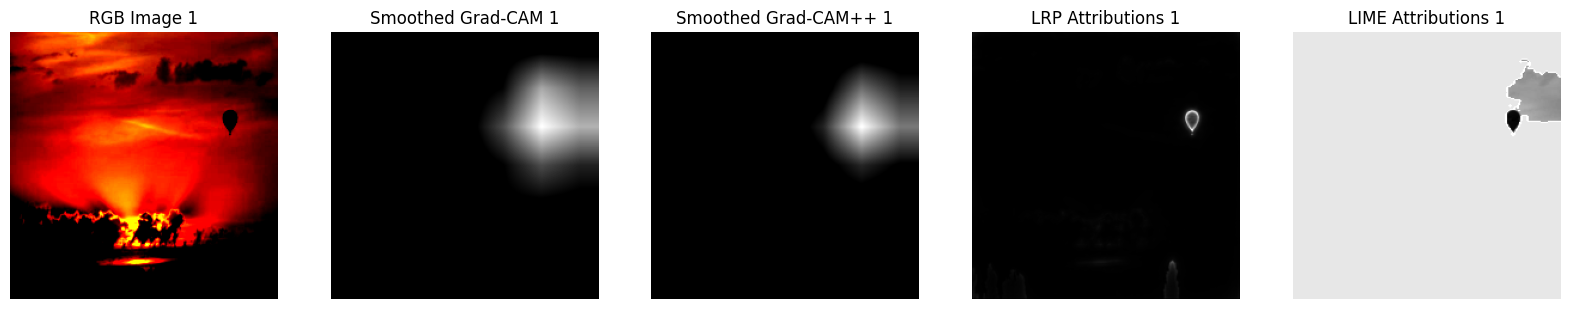

In [13]:
# FOR BATCH

import matplotlib.pyplot as plt
import numpy as np

batch_size = x_batch.shape[0]  # Number of images in the batch

for i in range(1):
    # Convert RGB image from PyTorch format (C, H, W) to (H, W, C) for matplotlib
    rgb_image = x_batch[i].detach().cpu().numpy().transpose(1, 2, 0)
    
    # Ensure values are in the range [0, 1] for proper plotting
    rgb_image = np.clip(rgb_image, 0, 1)
    
    # Grayscale images (assuming they are normalized and ready to plot)
    grayscale_grad_cam_thr_plot = grayscale_grad_cam_thr[i]  # Shape (224, 224)
    grayscale_grad_cam_pp_thr_plot = grayscale_grad_cam_pp_thr[i]  # Shape (224, 224)
    attributions_lrp_np_plot = attributions_lrp_np[i]  # Shape (224, 224)
    marked_image_gray_plot = marked_images_gray_batch[i]  # LIME result
    # marked_images_gray_batch.append(marked_image_gray_plot)
    # Plot all images (RGB + 3 grayscale)
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

    # Plot RGB image
    axes[0].imshow(rgb_image)
    axes[0].title.set_text(f"RGB Image {i+1}")
    axes[0].axis('off')

    # Plot Grayscale Grad-CAM
    axes[1].imshow(grayscale_grad_cam_thr_plot, cmap="gray")
    axes[1].title.set_text(f"Smoothed Grad-CAM {i+1}")
    axes[1].axis('off')

    # Plot Grayscale Grad-CAM++
    axes[2].imshow(grayscale_grad_cam_pp_thr_plot, cmap="gray")
    axes[2].title.set_text(f"Smoothed Grad-CAM++ {i+1}")
    axes[2].axis('off')

    # Plot Grayscale LRP
    axes[3].imshow(attributions_lrp_np_plot, cmap="gray")
    axes[3].title.set_text(f"LRP Attributions {i+1}")
    axes[3].axis('off')

    # Plot Grayscale LIME
    axes[4].imshow(marked_image_gray_plot, cmap="gray")
    axes[4].title.set_text(f"LIME Attributions {i+1}")
    axes[4].axis('off')

    # Display the plot for the current batch image
    plt.show()


In [195]:
(marked_images_gray_batch)

numpy.ndarray

In [ ]:
grayscale_grad_cam_thr_plot_binary = np.where(grayscale_grad_cam_thr_plot!=0,1,0)
plt.imshow(grayscale_grad_cam_thr_plot_binary)

In [ ]:
attributions_lrp_np_plot_binary = np.where(attributions_lrp_np_plot >= 0.2, 1, 0)
plt.imshow(attributions_lrp_np_plot_binary)

In [ ]:
grayscale_grad_cam_pp_thr_plot_binary = np.where(grayscale_grad_cam_pp_thr_plot!=0,1,0)
plt.imshow(grayscale_grad_cam_pp_thr_plot_binary)

In [ ]:
marked_image_gray_plot_binary = np.where(marked_image_gray >= 0.2, 1, 0)
plt.imshow(marked_image_gray_plot_binary)

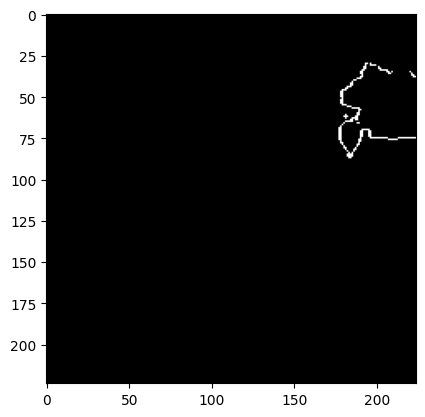

In [15]:
# Intersection points : 

grayscale_grad_cam_thr_plot_binary = np.where(grayscale_grad_cam_thr_plot!=0,1,0)
grayscale_grad_cam_pp_thr_plot_binary = np.where(grayscale_grad_cam_pp_thr_plot!=0,1,0)
marked_image_gray_plot_binary = np.where(marked_image_gray >= 0.2, 1, 0)
marked_image_gray_plot_binary = np.squeeze(marked_image_gray_plot_binary)

attributions_lrp_np_plot_binary = np.where(attributions_lrp_np_plot >= 0.2, 1, 0)

intersection = np.logical_and(
    np.logical_and(grayscale_grad_cam_thr_plot_binary, grayscale_grad_cam_pp_thr_plot_binary),
    np.logical_and(marked_image_gray_plot_binary, marked_image_gray_plot_binary)
)

# Convert the logical array to integer values (0 and 1)
intersection = intersection.astype(int)
plt.imshow(intersection, cmap="gray")
intersection = np.expand_dims(intersection, axis=0)

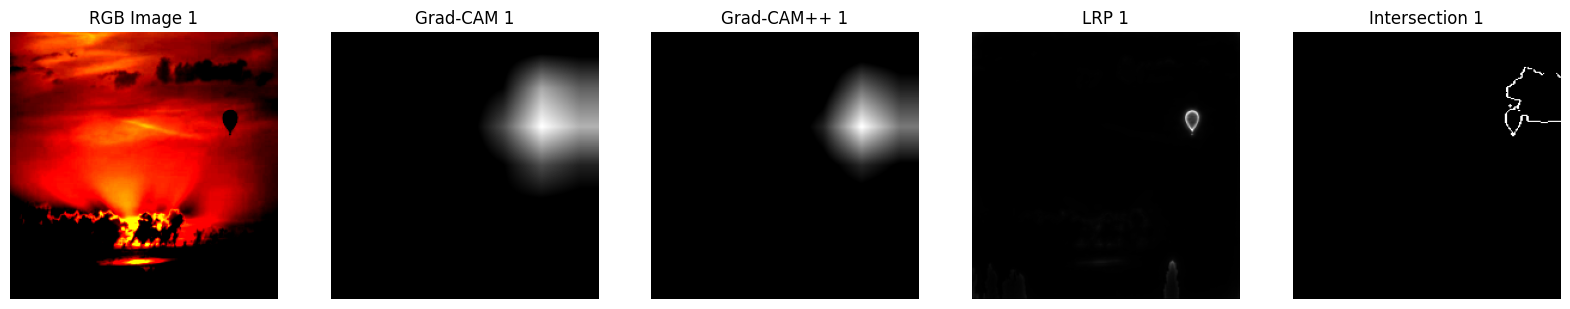

In [17]:
# FOR BATCH
import matplotlib.pyplot as plt
import numpy as np

batch_size = x_batch.shape[0]  # Number of images in the batch

for i in range(1):
    # Get the image and corresponding results for this batch index
    grayscale_grad_cam_thr_plot = grayscale_grad_cam_thr[i]
    grayscale_grad_cam_pp_thr_plot = grayscale_grad_cam_pp_thr[i]
    marked_image_gray_plot = marked_images_gray_batch[i]
    attributions_lrp_np_plot = attributions_lrp_np[i]

    # Convert to binary
    grayscale_grad_cam_thr_plot_binary = np.where(grayscale_grad_cam_thr_plot != 0, 1, 0)
    grayscale_grad_cam_pp_thr_plot_binary = np.where(grayscale_grad_cam_pp_thr_plot != 0, 1, 0)
    marked_image_gray_plot_binary = np.where(marked_image_gray_plot >= 0.2, 1, 0)
    marked_image_gray_plot_binary = np.squeeze(marked_image_gray_plot_binary)
    attributions_lrp_np_plot_binary = np.where(attributions_lrp_np_plot >= 0.2, 1, 0)

    # Compute the intersection
    intersection = np.logical_and(
        np.logical_and(grayscale_grad_cam_thr_plot_binary, grayscale_grad_cam_pp_thr_plot_binary),
        np.logical_and(marked_image_gray_plot_binary, marked_image_gray_plot_binary)
    )

    # Convert the logical array to integer values (0 and 1)
    intersection = intersection.astype(int)

    # Plot all images and intersection for this batch image
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

    # Plot RGB image
    rgb_image = x_batch[i].detach().cpu().numpy().transpose(1, 2, 0)
    rgb_image = np.clip(rgb_image, 0, 1)
    axes[0].imshow(rgb_image)
    axes[0].title.set_text(f"RGB Image {i+1}")
    axes[0].axis('off')

    # Plot Grayscale Grad-CAM
    axes[1].imshow(grayscale_grad_cam_thr_plot, cmap="gray")
    axes[1].title.set_text(f"Grad-CAM {i+1}")
    axes[1].axis('off')

    # Plot Grayscale Grad-CAM++
    axes[2].imshow(grayscale_grad_cam_pp_thr_plot, cmap="gray")
    axes[2].title.set_text(f"Grad-CAM++ {i+1}")
    axes[2].axis('off')

    # Plot Grayscale LRP
    axes[3].imshow(attributions_lrp_np_plot, cmap="gray")
    axes[3].title.set_text(f"LRP {i+1}")
    axes[3].axis('off')

    # Plot Intersection
    axes[4].imshow(intersection, cmap="gray")
    axes[4].title.set_text(f"Intersection {i+1}")
    axes[4].axis('off')

    # Display the plot for the current batch image
    plt.show()


In [139]:
# FOR BATCH
import numpy as np
import torch
import cv2
from torchvision import models
from lime import lime_image
from skimage.color import rgb2gray

def explainer_wrapper_v2(model, inputs, targets, **kwargs) -> np.ndarray:
    """Wrapper for explainer functions."""
    def batch_predict(images):
        model.eval()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        images = torch.stack([torchvision.transforms.functional.to_tensor(image) for image in images])
        images = images.to(device)
        outputs = model(images)
        probs = outputs.cpu().detach().numpy()
        return probs
    grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
    grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
    targets_tensor = torch.tensor(targets, dtype=torch.int64).to(device)

    if kwargs["method"] == "GradCAM":
        grayscale_grad_cam = grad_cam(input_tensor=inputs_tensor)
        grayscale_grad_cam = (grayscale_grad_cam.T / np.max(grayscale_grad_cam, axis=(1, 2)).T).T
        grayscale_grad_cam = np.expand_dims(grayscale_grad_cam, axis=(1))
        return grayscale_grad_cam
    
    elif kwargs["method"] == "GradCAMPP":
        grayscale_grad_cam_pp = grad_cam_pp(input_tensor=inputs_tensor)
        grayscale_grad_cam_pp = (grayscale_grad_cam_pp.T / np.max(grayscale_grad_cam_pp, axis=(1, 2)).T).T
        grayscale_grad_cam_pp = np.expand_dims(grayscale_grad_cam_pp, axis=(1))
        return grayscale_grad_cam_pp
    
    elif kwargs["method"] == "LRP":
        attributions_lrp = LRP(model, input=inputs_tensor, target=targets_tensor)
        attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        attributions_lrp_np = (attributions_lrp_np.T / np.max(attributions_lrp_np, axis=(1, 2)).T).T
        attributions_lrp_np = np.expand_dims(attributions_lrp_np, axis=(1))
        return attributions_lrp_np
    
    elif kwargs["method"] == "Proposed_method":
        grayscale_grad_cam_pp = grad_cam_pp(input_tensor=inputs_tensor)
        grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
        grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.2
        grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)

        attributions_lrp = LRP(model, input=inputs_tensor, target=targets_tensor)
        attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        product = attributions_lrp_np * grayscale_grad_cam_pp_thr
        for i in range(product.shape[0]):
            product[i] = cv2.GaussianBlur(product[i], (5, 5), cv2.BORDER_DEFAULT)
        product = (product.T / np.max(product, axis=(1, 2)).T).T
        product = np.expand_dims(product, axis=(1))
        return product
    elif kwargs["method"] == "LIME":
        def batch_predict(images):
            model.eval()
            images_tensor = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
            images_tensor = images_tensor.to(device)
            outputs = model(images_tensor)
            probs = outputs.cpu().detach().numpy()
            return probs

        # Normalize the batch
        mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
        std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
        input_norm = (inputs_tensor - mean) / std  # Normalize input

        # Initialize LIME explainer
        explainer = lime_image.LimeImageExplainer()

        # Loop over each image in the batch and apply LIME
        temps_masks = []  # List to store (temp, mask) for each image
        for i in range(input_norm.shape[0]):
            input_image = input_norm[i].cpu().detach().numpy()
            input_image = np.moveaxis(input_image, 0, -1)  # Convert to channel-last for LIME
            
            # Generate LIME explanation for the current image
            explanation = explainer.explain_instance(input_image,
                                                    batch_predict,
                                                    top_labels=1, 
                                                    hide_color=0,
                                                    num_samples=10)
            
            # Get temp and mask for the top class
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=True,
                                                        num_features=1,
                                                        hide_rest=True)
            temps_masks.append((temp, mask))  # Append the results for this image

        # Convert list of results to numpy arrays if needed
        temps, masks = zip(*temps_masks)
        temps = np.array(temps)
        masks = np.array(masks)

        marked_images_gray_batch = []

        # Loop over the batch of temps and masks
        for temp, mask in zip(temps, masks):
            # Apply boundary marking to the current temp and mask
            marked_image_rgb = mark_boundaries(temp, mask, color=(1, 1, 1))
            
            # Convert the marked image to grayscale
            marked_image_gray = rgb2gray(marked_image_rgb)
            
            # Expand the dimensions to add a channel axis (if necessary)
            marked_image_gray = np.expand_dims(marked_image_gray, axis=-1)
            
            # Append the processed grayscale image to the list
            marked_images_gray_batch.append(marked_image_gray)

        # Convert the batch list to a numpy array if needed
        marked_images_gray_batch = np.array(marked_images_gray_batch)
        return marked_images_gray_batch
    
    elif kwargs["method"] == "Intersection":
        def compute_binary(mask, threshold):
            """Convert mask to binary using the given threshold."""
            return np.where(mask >= threshold, 1, 0)
        # Initialize explainers
        # grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
        # grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])
        
        # # Get the explanations
        # grayscale_grad_cam = grad_cam(input_tensor=inputs_tensor)
        # grayscale_grad_cam_pp = grad_cam_pp(input_tensor=inputs_tensor)
        # attributions_lrp = LRP(model, input=inputs_tensor, target=targets_tensor)
        

        
        # # Convert LIME marked images to binary
        # mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
        # std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
        # input_norm = (inputs_tensor - mean) / std  # Normalize input
        # # marked_images_gray_batch = explainer_wrapper_v2(model, input_norm, targets_tensor, method='LIME')



        # # Initialize LIME explainer
        # explainer = lime_image.LimeImageExplainer()

        # # Loop over each image in the batch and apply LIME
        # temps_masks = []  # List to store (temp, mask) for each image
        # for i in range(input_norm.shape[0]):
        #     input_image = input_norm[i].cpu().detach().numpy()
        #     input_image = np.moveaxis(input_image, 0, -1)  # Convert to channel-last for LIME
            
        #     # Generate LIME explanation for the current image
        #     explanation = explainer.explain_instance(input_image,
        #                                             batch_predict,
        #                                             top_labels=1, 
        #                                             hide_color=0,
        #                                             num_samples=1)
            
        #     # Get temp and mask for the top class
        #     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
        #                                                 positive_only=True,
        #                                                 num_features=1,
        #                                                 hide_rest=True)
        #     temps_masks.append((temp, mask))  # Append the results for this image

        # # Convert list of results to numpy arrays if needed
        # temps, masks = zip(*temps_masks)
        # temps = np.array(temps)
        # masks = np.array(masks)

        # marked_images_gray_batch = []

        # # Loop over the batch of temps and masks
        # for temp, mask in zip(temps, masks):
        #     # Apply boundary marking to the current temp and mask
        #     marked_image_rgb = mark_boundaries(temp, mask, color=(1, 1, 1))
            
        #     # Convert the marked image to grayscale
        #     marked_image_gray = rgb2gray(marked_image_rgb)
            
        #     # Expand the dimensions to add a channel axis (if necessary)
        #     marked_image_gray = np.expand_dims(marked_image_gray, axis=-1)
            
        #     # Append the processed grayscale image to the list
        #     marked_images_gray_batch.append(marked_image_gray)

        # # Convert the batch list to a numpy array if needed
        # marked_images_gray_batch = np.array(marked_images_gray_batch)

        # # Compute binary masks
        # grayscale_grad_cam_thr_plot_binary = compute_binary(grayscale_grad_cam, 0.2)
        # grayscale_grad_cam_pp_thr_plot_binary = compute_binary(grayscale_grad_cam_pp, 0.2)
        # marked_image_gray_plot_binary = compute_binary(marked_images_gray_batch, 0.2)
        # marked_image_gray_plot_binary= marked_image_gray_plot_binary[..., 0]
        # attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        # attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        # attributions_lrp_np_plot_binary = compute_binary(attributions_lrp_np, 0.2)
        
        # print("grayscale_grad_cam_thr_plot_binary", grayscale_grad_cam_thr_plot_binary.shape)
        # print("grayscale_grad_cam_pp_thr_plot_binary", grayscale_grad_cam_pp_thr_plot_binary.shape)
        # print("marked_image_gray_plot_binary", marked_image_gray_plot_binary.shape)
        # print("attributions_lrp_np_plot_binary", attributions_lrp_np_plot_binary.shape)
        

        # ret = []
        # for i in range(input_norm.shape[0]):
        #     # Get the image and corresponding results for this batch index


        #     # Compute the intersection
        #     intersection = np.logical_and(
        #         np.logical_and(grayscale_grad_cam_thr_plot_binary[i], grayscale_grad_cam_pp_thr_plot_binary[i]),
        #         np.logical_and(marked_image_gray_plot_binary[i], marked_image_gray_plot_binary[i])
        #     )

        #     # Convert the logical array to integer values (0 and 1)
        #     intersection = intersection.astype(int)

        #     # Convert the logical array to integer values (0 and 1)
        #     # intersection = intersection.astype(int)
        #     ret.append(intersection)
        #     print(max(intersection.flatten()))
        # return np.array(ret)
        grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
        grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])
        
        # Get the explanations
        grayscale_grad_cam = grad_cam(input_tensor=inputs_tensor)
        grayscale_grad_cam_pp = grad_cam_pp(input_tensor=inputs_tensor)
        attributions_lrp = LRP(model, input=inputs_tensor, target=targets_tensor)
        

        def batch_predict(images):
            model.eval()
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            images = torch.stack([torchvision.transforms.functional.to_tensor(image) for image in images])
            images = images.to(device)
            outputs = model(images)
            probs = outputs.cpu().detach().numpy()
            return probs

        input = inputs
        mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
        std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
        input_norm = (input - mean) / std  # Normalize input


        # Initialize LIME explainer
        explainer = lime_image.LimeImageExplainer()

        # Loop over each image in the batch and apply LIME

        # Loop over each image in the batch and apply LIME
        temps_masks = []  # List to store (temp, mask) for each image
        for i in range(input_norm.shape[0]):
            input_image = input_norm[i].cpu().detach().numpy()
            input_image = np.moveaxis(input_image, 0, -1)  # Convert to channel-last for LIME
            
            # Generate LIME explanation for the current image
            explanation = explainer.explain_instance(input_image,
                                                    batch_predict,
                                                    top_labels=1, 
                                                    hide_color=0,
                                                    num_samples=10)
            
            # Get temp and mask for the top class
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=True,
                                                        num_features=1,
                                                        hide_rest=True)
            temps_masks.append((temp, mask))  # Append the results for this ima

        # Convert list of results to numpy arrays if needed
        temps, masks = zip(*temps_masks)
        temps = np.array(temps)
        masks = np.array(masks)

        marked_images_gray_batch = []

        # Loop over the batch of temps and masks
        for temp, mask in zip(temps, masks):
            # Apply boundary marking to the current temp and mask
            marked_image_rgb = mark_boundaries(temp, mask, color=(1, 1, 1))
            
            # Convert the marked image to grayscale
            marked_image_gray = rgb2gray(marked_image_rgb)
            
            # Expand the dimensions to add a channel axis (if necessary)
            marked_image_gray = np.expand_dims(marked_image_gray, axis=-1)
            
            # Append the processed grayscale image to the list
            marked_images_gray_batch.append(marked_image_gray)

        # Convert the batch list to a numpy array if needed
        marked_images_gray_batch = np.array(marked_images_gray_batch)

        # Compute binary masks
        grayscale_grad_cam_thr_plot_binary = compute_binary(grayscale_grad_cam, 0.2)
        grayscale_grad_cam_pp_thr_plot_binary = compute_binary(grayscale_grad_cam_pp, 0.2)
        marked_image_gray_plot_binary = compute_binary(marked_images_gray_batch, 0.2)
        marked_image_gray_plot_binary= marked_image_gray_plot_binary[..., 0]
        attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        attributions_lrp_np_plot_binary = compute_binary(attributions_lrp_np, 0.2)
        
        print("grayscale_grad_cam_thr_plot_binary", grayscale_grad_cam_thr_plot_binary.shape)
        print("grayscale_grad_cam_pp_thr_plot_binary", grayscale_grad_cam_pp_thr_plot_binary.shape)
        print("marked_image_gray_plot_binary", marked_image_gray_plot_binary.shape)
        print("attributions_lrp_np_plot_binary", attributions_lrp_np_plot_binary.shape)
        

        ret = []
        for i in range(input_norm.shape[0]):
            # Get the image and corresponding results for this batch index


            # Compute the intersection
            intersection = np.logical_and(
                np.logical_and(grayscale_grad_cam_thr_plot_binary[i], grayscale_grad_cam_pp_thr_plot_binary[i]),
                np.logical_and(marked_image_gray_plot_binary[i], marked_image_gray_plot_binary[i])
            )

            # Convert the logical array to integer values (0 and 1)
            intersection = intersection.astype(int)

            # Convert the logical array to integer values (0 and 1)
            # intersection = intersection.astype(int)
            ret.append(intersection)
            print(max(intersection.flatten()))
        return np.array(ret)
    else:
        raise ValueError("Pick an explanation function that exists.")


In [ ]:
# FOR BATCH 
metrics = {
    # "Robustness": quantus.AvgSensitivity(
    #     nr_samples=10,
    #     lower_bound=0.2,
    #     norm_numerator=quantus.norm_func.fro_norm,
    #     norm_denominator=quantus.norm_func.fro_norm,
    #     perturb_func=quantus.perturb_func.uniform_noise,
    #     similarity_func=quantus.similarity_func.difference,
    #     abs=False,
    #     normalise=False,
    #     aggregate_func=np.mean,
    #     return_aggregate=True,
    #     disable_warnings=True,
    # ),
    "Faithfulness": quantus.FaithfulnessCorrelation(
        nr_runs=10,
        subset_size=224,
        perturb_baseline="uniform",
        perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
        similarity_func=quantus.similarity_func.correlation_pearson,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    )
    # "Localisation": quantus.RelevanceRankAccuracy(
    #     abs=False,
    #     normalise=False,
    #     aggregate_func=np.mean,
    #     return_aggregate=True,
    #     disable_warnings=True,
    # ),
    # "Complexity": quantus.Sparseness(
    #     abs=True,
    #     normalise=False,
    #     aggregate_func=np.mean,
    #     return_aggregate=True,
    #     disable_warnings=True,
    # )#,
    # "Randomisation": quantus.RandomLogit(
    #     num_classes=1000,
    #     similarity_func=quantus.similarity_func.ssim,
    #     abs=True,
    #     normalise=False,
    #     aggregate_func=np.mean,
    #     return_aggregate=True,
    #     disable_warnings=True,
    # ),
}
model.eval()
xai_methods = ['Intersection','LRP','GradCAM','GradCAMPP' ]
results = {method : {} for method in xai_methods}

for method in xai_methods:
    for metric, metric_func in metrics.items():
        print(f"Evaluating {metric} of {method} method.")
        scores = metric_func(
            model=model,
            x_batch=x_batch[:1].cpu().detach().numpy(),
            y_batch=y_batch[:1].cpu().detach().numpy(),
            a_batch=None,
            s_batch=s_batch[:1].cpu().detach().numpy(),
            explain_func=explainer_wrapper_v2,
            explain_func_kwargs={
                "method": method,
            },
        )
        results[method][metric] = scores

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6736\1324644806.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_tensor = torch.tensor(x_batch[:1], dtype=torch.float32).to(device)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6736\1324644806.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_tensor = torch.tensor(y_batch[:1], dtype=torch.int64).to(device)


  0%|          | 0/100 [00:00<?, ?it/s]

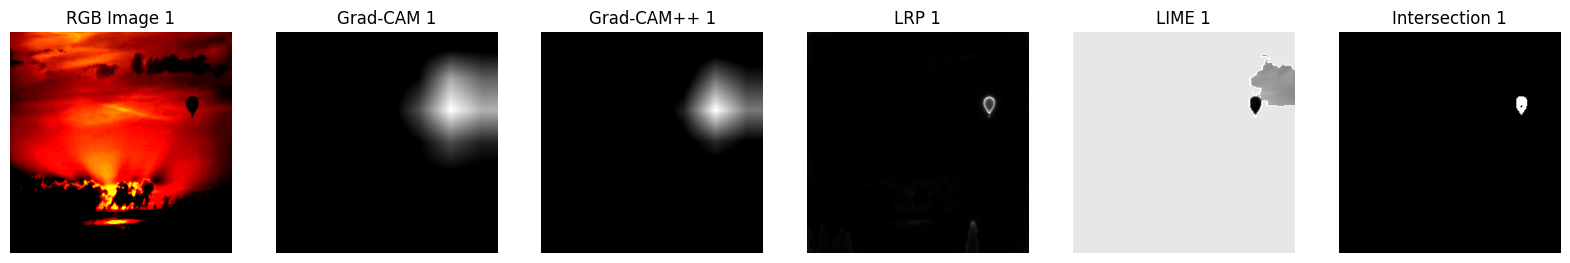

In [43]:
# # device = 'cpu'
# # inputs_tensor = torch.tensor(x_batch[:1], dtype=torch.float32).to(device)
# # targets_tensor = torch.tensor(y_batch[:1], dtype=torch.int64).to(device)
# # def compute_binary(mask, threshold):
# #     """Convert mask to binary using the given threshold."""
# #     return np.where(mask >= threshold, 1, 0)
# # grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
# # grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])

# # # Get the explanations
# # grayscale_grad_cam = grad_cam(input_tensor=inputs_tensor)
# # grayscale_grad_cam_pp = grad_cam_pp(input_tensor=inputs_tensor)


# # attributions_lrp = LRP(model, input = inputs_tensor ,target=targets_tensor )



# # attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
# # attributions_lrp_np = np.transpose(attributions_lrp_np, (0,2,3,1))
# # attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
# # attributions_lrp_np = (attributions_lrp_np.T/np.max(attributions_lrp_np, axis=(1,2)).T).T



# # # Convert LIME marked images to binary
# # mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
# # std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
# # input_norm = (inputs_tensor - mean) / std  # Normalize input
# # # marked_images_gray_batch = explainer_wrapper_v2(model, input_norm, targets_tensor, method='LIME')


# # input = x_batch[0:1]

# # # Normalize the batch
# # mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
# # std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
# # input_norm = (input - mean) / std  # Normalize input

# # # Initialize LIME explainer
# # explainer = lime_image.LimeImageExplainer()

# # # Loop over each image in the batch and apply LIME
# # temps_masks = []  # List to store (temp, mask) for each image
# # for i in range(input_norm.shape[0]):
# #     input_image = input_norm[i].cpu().detach().numpy()
# #     input_image = np.moveaxis(input_image, 0, -1)  # Convert to channel-last for LIME
    
# #     # Generate LIME explanation for the current image
# #     explanation = explainer.explain_instance(input_image,
# #                                              batch_predict,
# #                                              top_labels=1, 
# #                                              hide_color=0,
# #                                              num_samples=10)
    
# #     # Get temp and mask for the top class
# #     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
# #                                                 positive_only=True,
# #                                                 num_features=1,
# #                                                 hide_rest=True)
# #     temps_masks.append((temp, mask))  # Append the results for this image

# # # Convert list of results to numpy arrays if needed
# # temps, masks = zip(*temps_masks)
# # temps = np.array(temps)
# # masks = np.array(masks)


# # # Initialize an empty list to hold the grayscale images with boundaries
# # marked_images_gray_batch = []

# # # Loop over the batch of temps and masks
# # for temp, mask in zip(temps, masks):
# #     # Apply boundary marking to the current temp and mask
# #     marked_image_rgb = mark_boundaries(temp, mask, color=(1, 1, 1))
    
# #     # Convert the marked image to grayscale
# #     marked_image_gray = rgb2gray(marked_image_rgb)
    
# #     # Expand the dimensions to add a channel axis (if necessary)
# #     marked_image_gray = np.expand_dims(marked_image_gray, axis=-1)
    
# #     # Append the processed grayscale image to the list
# #     marked_images_gray_batch.append(marked_image_gray)

# # # Convert the batch list to a numpy array if needed
# # marked_images_gray_batch = np.array(marked_images_gray_batch)


# # # Compute binary masks
# # grayscale_grad_cam_thr_plot_binary = compute_binary(grayscale_grad_cam, 0.2)
# # grayscale_grad_cam_pp_thr_plot_binary = compute_binary(grayscale_grad_cam_pp, 0.2)
# # marked_image_gray_plot_binary = np.where(marked_images_gray_batch >= 0.0, 1, 0)
# # marked_image_gray_plot_binary = np.squeeze(marked_image_gray_plot_binary)
# # attributions_lrp_np_plot_binary = compute_binary(attributions_lrp_np, 0.2)

# # print("grayscale_grad_cam_thr_plot_binary", grayscale_grad_cam_thr_plot_binary.shape)
# # print("grayscale_grad_cam_pp_thr_plot_binary", grayscale_grad_cam_pp_thr_plot_binary.shape)
# # print("marked_image_gray_plot_binary", marked_image_gray_plot_binary.shape)
# # print("attributions_lrp_np_plot_binary", attributions_lrp_np_plot_binary.shape)


# # ret = []
# # for i in range(input_norm.shape[0]):
# #     # Get the image and corresponding results for this batch index


# #     # Compute the intersection
# #     intersection = np.logical_and(
# #         np.logical_and(grayscale_grad_cam_thr_plot_binary[i], grayscale_grad_cam_pp_thr_plot_binary[i]),
# #         np.logical_and(marked_image_gray_plot_binary[i], attributions_lrp_np_plot_binary[i])
# #     )

# #     # Convert the logical array to integer values (0 and 1)
# #     intersection = intersection.astype(int)

# #     # Convert the logical array to integer values (0 and 1)
# #     # intersection = intersection.astype(int)
# #     ret.append(intersection)
# #     print(max(intersection.flatten()))





# # #     # Plot all images and intersection for this batch image
# #     fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# #     # Plot RGB image
# #     rgb_image = x_batch[i].detach().cpu().numpy().transpose(1, 2, 0)
# #     rgb_image = np.clip(rgb_image, 0, 1)
# #     axes[0].imshow(rgb_image)
# #     axes[0].title.set_text(f"RGB Image {i+1}")
# #     axes[0].axis('off')

# #     # Plot Grayscale Grad-CAM
# #     axes[1].imshow(grayscale_grad_cam_thr_plot_binary[i], cmap="gray")
# #     axes[1].title.set_text(f"Grad-CAM {i+1}")
# #     axes[1].axis('off')

# #     # Plot Grayscale Grad-CAM++
# #     axes[2].imshow(grayscale_grad_cam_pp_thr_plot_binary[i], cmap="gray")
# #     axes[2].title.set_text(f"Grad-CAM++ {i+1}")
# #     axes[2].axis('off')

# #     # Plot Grayscale LRP
# #     axes[3].imshow(attributions_lrp_np_plot_binary[i], cmap="gray")
# #     axes[3].title.set_text(f"LRP {i+1}")
# #     axes[3].axis('off')

# #     # Plot Intersection
# #     axes[4].imshow(intersection, cmap="gray")
# #     axes[4].title.set_text(f"Intersection {i+1}")
# #     axes[4].axis('off')

# #     # Display the plot for the current batch image
# #     plt.show()




# # ***
device = 'cpu'
x = x_batch[:1]
y = y_batch[:1]
inputs_tensor = torch.tensor(x_batch[:1], dtype=torch.float32).to(device)
targets_tensor = torch.tensor(y_batch[:1], dtype=torch.int64).to(device)
def compute_binary(mask, threshold):
    """Convert mask to binary using the given threshold."""
    return np.where(mask >= threshold, 1, 0)


grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])



# Get the explanations

grayscale_grad_cam = grad_cam(input_tensor=x )
grayscale_grad_cam_pp = grad_cam_pp(input_tensor=x )
attributions_lrp = LRP(model, input = x ,target=y )



attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
attributions_lrp_np = np.transpose(attributions_lrp_np, (0,2,3,1))
attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
attributions_lrp_np = (attributions_lrp_np.T/np.max(attributions_lrp_np, axis=(1,2)).T).T


# Threshold GradCAM results
grayscale_grad_cam_thr = np.copy(grayscale_grad_cam)
grayscale_grad_cam_thr = grayscale_grad_cam_thr - 0.2
grayscale_grad_cam_thr = np.clip(grayscale_grad_cam_thr, 0, 1)
product_grad_cam = attributions_lrp_np * grayscale_grad_cam_thr
product_grad_cam = (product_grad_cam.T / np.max(product_grad_cam, axis=(1, 2)).T).T


# Threshold GradCAMPP results
grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.2
grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
product_grad_cam_pp = attributions_lrp_np * grayscale_grad_cam_pp_thr
product_grad_cam_pp = (product_grad_cam_pp.T / np.max(product_grad_cam_pp, axis=(1, 2)).T).T

# Smooth the GradCAM result
smoothed_grad_cam = np.zeros(product_grad_cam.shape)
for i in range(0, product_grad_cam.shape[0]):
    smoothed_grad_cam[i] = cv2.GaussianBlur(product_grad_cam[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam[i] = smoothed_grad_cam[i] / np.max(smoothed_grad_cam[i])

# Smooth the GradCAM result
smoothed_grad_cam_pp = np.zeros(product_grad_cam_pp.shape)
for i in range(0, product_grad_cam_pp.shape[0]):
    smoothed_grad_cam_pp[i] = cv2.GaussianBlur(product_grad_cam_pp[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam_pp[i] = smoothed_grad_cam_pp[i] / np.max(smoothed_grad_cam_pp[i])






def batch_predict(images):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    images = torch.stack([torchvision.transforms.functional.to_tensor(image) for image in images])
    images = images.to(device)
    outputs = model(images)
    probs = outputs.cpu().detach().numpy()
    return probs

input = x_batch[0:1]

# Normalize the batch
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
input_norm = (input - mean) / std  # Normalize input

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Loop over each image in the batch and apply LIME
temps_masks = []  # List to store (temp, mask) for each image
for i in range(input_norm.shape[0]):
    input_image = input_norm[i].cpu().detach().numpy()
    input_image = np.moveaxis(input_image, 0, -1)  # Convert to channel-last for LIME
    
    # Generate LIME explanation for the current image
    explanation = explainer.explain_instance(input_image,
                                             batch_predict,
                                             top_labels=1, 
                                             hide_color=0,
                                             num_samples=100)
    
    # Get temp and mask for the top class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=1,
                                                hide_rest=True)
    temps_masks.append((temp, mask))  # Append the results for this image

# Convert list of results to numpy arrays if needed
temps, masks = zip(*temps_masks)
temps = np.array(temps)
masks = np.array(masks)

# Initialize an empty list to hold the grayscale images with boundaries
marked_images_gray_batch = []

# Loop over the batch of temps and masks
for temp, mask in zip(temps, masks):
    # Apply boundary marking to the current temp and mask
    marked_image_rgb = mark_boundaries(temp, mask, color=(1, 1, 1))
    
    # Convert the marked image to grayscale
    marked_image_gray = rgb2gray(marked_image_rgb)
    
    # Expand the dimensions to add a channel axis (if necessary)
    marked_image_gray = np.expand_dims(marked_image_gray, axis=-1)
    
    # Append the processed grayscale image to the list
    marked_images_gray_batch.append(marked_image_gray)

# Convert the batch list to a numpy array if needed
marked_images_gray_batch = np.array(marked_images_gray_batch)


for i in range(1):
    # Get the image and corresponding results for this batch index
    grayscale_grad_cam_thr_plot = grayscale_grad_cam_thr[i]
    grayscale_grad_cam_pp_thr_plot = grayscale_grad_cam_pp_thr[i]
    marked_image_gray_plot = marked_images_gray_batch[i]
    attributions_lrp_np_plot = attributions_lrp_np[i]

    # Convert to binary
    grayscale_grad_cam_thr_plot_binary = np.where(grayscale_grad_cam_thr_plot != 0, 1, 0)
    grayscale_grad_cam_pp_thr_plot_binary = np.where(grayscale_grad_cam_pp_thr_plot != 0, 1, 0)
    marked_image_gray_plot_binary = np.where(marked_image_gray_plot >= 0.2, 0, 1)
    marked_image_gray_plot_binary = np.squeeze(marked_image_gray_plot_binary)
    attributions_lrp_np_plot_binary = np.where(attributions_lrp_np_plot >= 0.2, 1, 0)

    # Compute the intersection
    intersection = np.logical_and(
        np.logical_and(grayscale_grad_cam_thr_plot_binary, grayscale_grad_cam_pp_thr_plot_binary),
        np.logical_and(marked_image_gray_plot_binary, attributions_lrp_np_plot_binary)
    )

    # Convert the logical array to integer values (0 and 1)
    intersection = intersection.astype(int)

    # Plot all images and intersection for this batch image
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

    # Plot RGB image
    rgb_image = x_batch[i].detach().cpu().numpy().transpose(1, 2, 0)
    rgb_image = np.clip(rgb_image, 0, 1)
    axes[0].imshow(rgb_image)
    axes[0].title.set_text(f"RGB Image {i+1}")
    axes[0].axis('off')

    # Plot Grayscale Grad-CAM
    axes[1].imshow(grayscale_grad_cam_thr_plot, cmap="gray")
    axes[1].title.set_text(f"Grad-CAM {i+1}")
    axes[1].axis('off')

    # Plot Grayscale Grad-CAM++
    axes[2].imshow(grayscale_grad_cam_pp_thr_plot, cmap="gray")
    axes[2].title.set_text(f"Grad-CAM++ {i+1}")
    axes[2].axis('off')

    # Plot Grayscale LRP
    axes[3].imshow(attributions_lrp_np_plot, cmap="gray")
    axes[3].title.set_text(f"LRP {i+1}")
    axes[3].axis('off')


    # Plot Intersection
    axes[4].imshow(marked_image_gray_plot, cmap="gray")
    axes[4].title.set_text(f"LIME {i+1}")
    axes[4].axis('off')


    # Plot Intersection
    axes[5].imshow(intersection, cmap="gray")
    axes[5].title.set_text(f"Intersection {i+1}")
    axes[5].axis('off')

    # Display the plot for the current batch image
    plt.show()



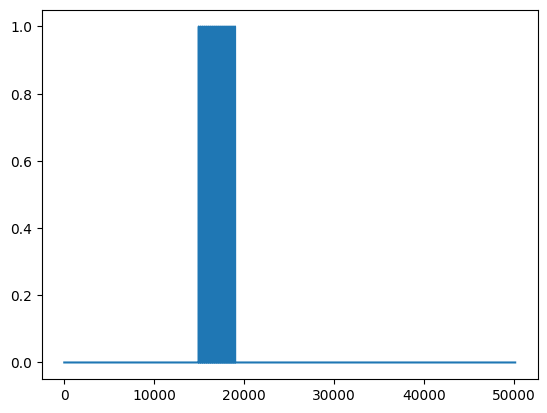

In [45]:
intersection = np.logical_and(
    np.logical_and(grayscale_grad_cam_thr_plot_binary, grayscale_grad_cam_pp_thr_plot_binary),
    np.logical_and(marked_image_gray_plot_binary, attributions_lrp_np_plot_binary)
)

plt.plot(intersection.flatten())

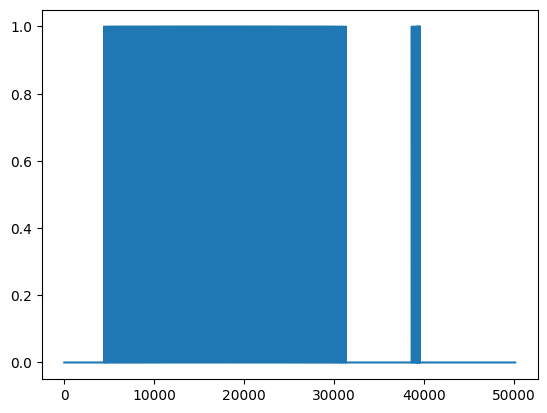

In [47]:
plt.plot(grayscale_grad_cam_thr_plot_binary.flatten())

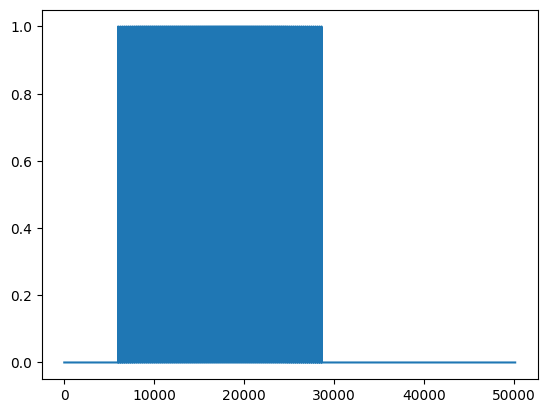

In [48]:
plt.plot(grayscale_grad_cam_pp_thr_plot_binary.flatten())

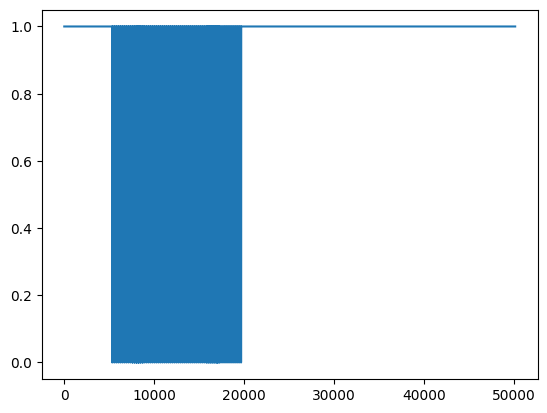

In [50]:
plt.plot(marked_image_gray_plot_binary.flatten())

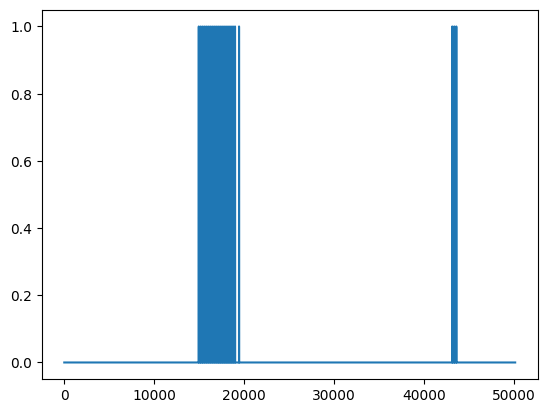

In [51]:
plt.plot(attributions_lrp_np_plot_binary.flatten())